# Federated Learning with ResNet50 for Lung Disease Classification
## Corrected and Complete Implementation

In [ ]:
# Data Processing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    cohen_kappa_score, matthews_corrcoef
)
from PIL import Image, ImageEnhance

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from tqdm import tqdm
import os
import random
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuration
CONFIG = {
    'IMG_SIZE': (224, 224),
    'BATCH_SIZE': 32,
    'EPOCHS': 50,
    'LEARNING_RATE': 0.0001,
    'NUM_CLIENTS': 3,  # Number of federated clients
    'FL_ROUNDS': 10,   # Federated learning rounds
    'LOCAL_EPOCHS': 5, # Epochs per client per round
    'EARLY_STOPPING_PATIENCE': 10,
    'REDUCE_LR_PATIENCE': 5
}

# Dataset paths
DATA_DIR = '/content/drive/MyDrive/Lung Dataset'

print("Configuration loaded successfully!")

Configuration loaded successfully!


In [ ]:
import os

DATA_DIR = '/content/drive/MyDrive/Lung Dataset'

if os.path.exists(DATA_DIR):
    print(f"Directory '{DATA_DIR}' exists.")
    print("Contents of the directory:")
    for item in os.listdir(DATA_DIR):
        print(f"  - {item}")
else:
    print(f"Directory '{DATA_DIR}' does NOT exist.")
    print("Please check the path and ensure the dataset is in your Google Drive.")


Directory '/content/drive/MyDrive/Lung Dataset' exists.
Contents of the directory:
  - Malignant
  - Normal
  - Benign


In [ ]:
# Load dataset
def load_dataset(data_dir):
    """
    Load images and labels from directory structure
    """
    all_paths = []
    all_labels = []

    # Get class names
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

    print(f"Found {len(classes)} classes: {classes}")

    # Load all image paths
    for label in classes:
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(label_dir, image_name)
                    all_paths.append(image_path)
                    all_labels.append(class_to_idx[label])

    # Shuffle data
    all_paths, all_labels = shuffle(all_paths, all_labels, random_state=42)

    print(f"\nDataset Statistics:")
    print(f"Total images: {len(all_paths)}")
    for cls, idx in class_to_idx.items():
        count = all_labels.count(idx)
        print(f"  {cls}: {count} images")

    return all_paths, all_labels, class_to_idx

# Load dataset
all_paths, all_labels, class_to_idx = load_dataset(DATA_DIR)
num_classes = len(class_to_idx)

# Split into train and test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_paths, all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

print(f"\nTrain-Test Split:")
print(f"Training images: {len(train_paths)}")
print(f"Testing images: {len(test_paths)}")

Found 3 classes: ['Benign', 'Malignant', 'Normal']

Dataset Statistics:
Total images: 1097
  Benign: 120 images
  Malignant: 561 images
  Normal: 416 images

Train-Test Split:
Training images: 877
Testing images: 220


In [ ]:
# Image preprocessing and augmentation
def augment_image(image):
    """
    Apply augmentation to image
    """
    # Convert to PIL Image
    image = Image.fromarray(np.uint8(image))

    # Random brightness
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))

    # Random contrast
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))

    # Random color
    if image.mode == 'RGB':
        image = ImageEnhance.Color(image).enhance(random.uniform(0.9, 1.1))

    # Random sharpness
    image = ImageEnhance.Sharpness(image).enhance(random.uniform(0.9, 1.1))

    # Random horizontal flip
    if random.random() > 0.5:
        image = image.transpose(Image.FLIP_LEFT_RIGHT)

    # Convert back to array and normalize
    image = np.array(image) / 255.0

    return image

def load_and_preprocess_image(path, img_size=(224, 224), augment=False):
    """
    Load and preprocess a single image
    """
    try:
        # Load image
        img = load_img(path, target_size=img_size)
        img_array = img_to_array(img)

        # Apply augmentation if requested
        if augment:
            img_array = augment_image(img_array)
        else:
            img_array = img_array / 255.0

        return img_array
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None

def create_dataset(paths, labels, img_size=(224, 224), augment=False, batch_size=32):
    """
    Create dataset from paths and labels
    """
    X = []
    y = []

    print(f"Loading {len(paths)} images...")
    for path, label in tqdm(zip(paths, labels), total=len(paths)):
        img = load_and_preprocess_image(path, img_size, augment)
        if img is not None:
            X.append(img)
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    # Convert labels to one-hot encoding
    y = keras.utils.to_categorical(y, num_classes=num_classes)

    return X, y

print("Data preprocessing functions defined!")

Data preprocessing functions defined!


Visualizing training samples...


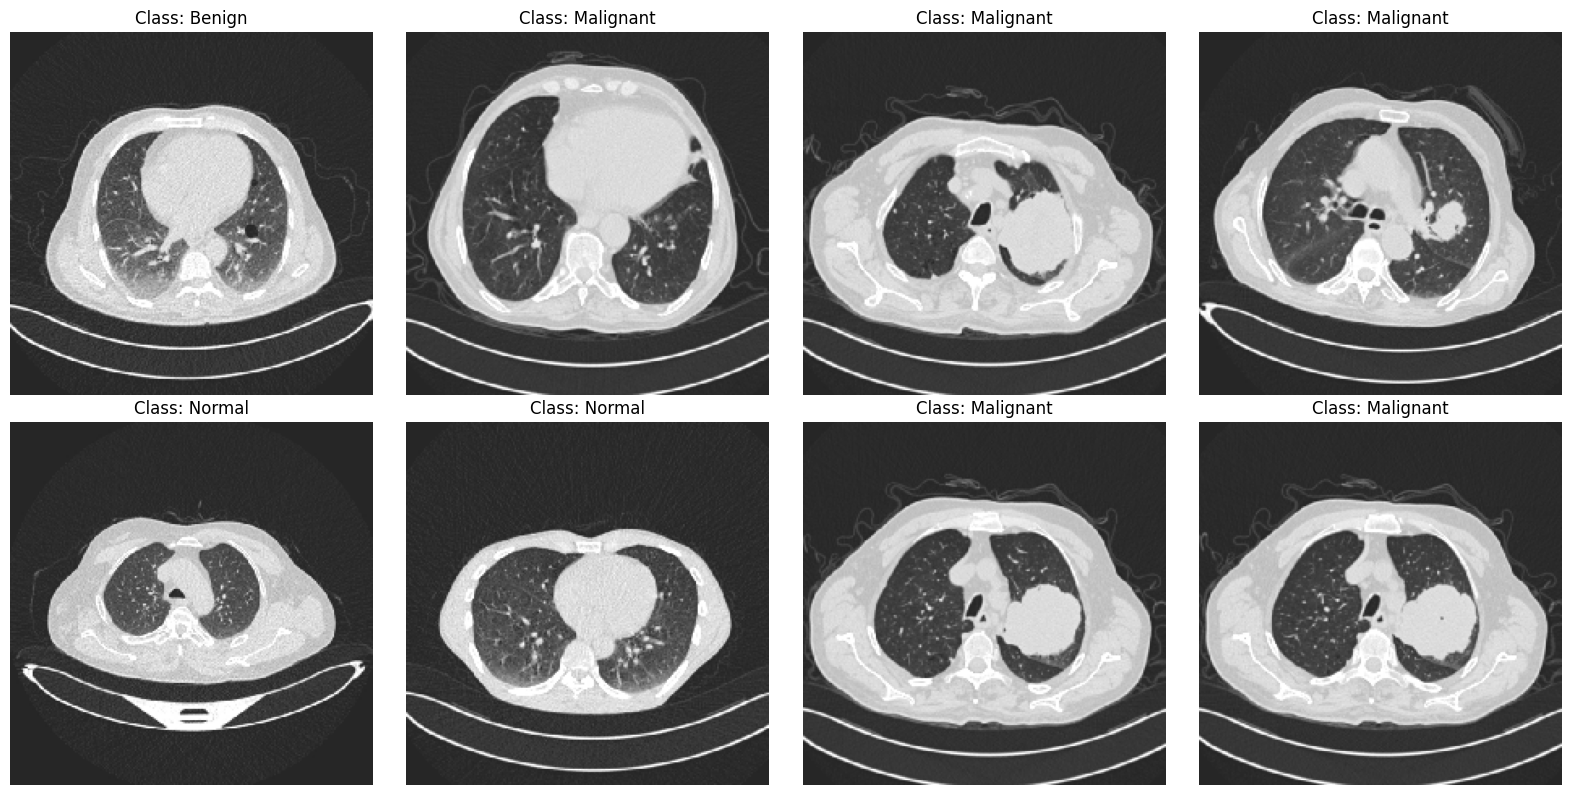

In [ ]:
# Visualize sample images
def visualize_samples(paths, labels, class_names, n_samples=8):
    """
    Visualize random samples from dataset
    """
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    indices = random.sample(range(len(paths)), n_samples)

    for i, idx in enumerate(indices):
        img = load_img(paths[idx], target_size=CONFIG['IMG_SIZE'])
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {class_names[labels[idx]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Get class names
idx_to_class = {v: k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(num_classes)]

print("Visualizing training samples...")
visualize_samples(train_paths, train_labels, class_names)

In [ ]:
# Build ResNet50 model
def build_resnet50_model(num_classes, img_size=(224, 224)):
    """
    Build ResNet50 model with custom head
    """
    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(*img_size, 3)
    )

    # Freeze base model layers initially
    base_model.trainable = False

    # Build custom head
    inputs = Input(shape=(*img_size, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    return model, base_model

# Create model
model, base_model = build_resnet50_model(num_classes, CONFIG['IMG_SIZE'])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

print("Model Architecture:")
model.summary()

print(f"\nTotal parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")

Model Architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,648,579 (94.03 MB)

 Trainable params: 1,055,747 (4.03 MB)

 Non-trainable params: 23,592,832 (90.00 MB)


Total parameters: 24,648,579
Trainable parameters: 1,055,747


In [ ]:
# Load training and testing data
print("Loading training data...")
X_train, y_train = create_dataset(
    train_paths, train_labels,
    CONFIG['IMG_SIZE'],
    augment=True
)

print("\nLoading testing data...")
X_test, y_test = create_dataset(
    test_paths, test_labels,
    CONFIG['IMG_SIZE'],
    augment=False
)

print(f"\nDataset shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Loading training data...
Loading 877 images...


100%|██████████| 877/877 [04:28<00:00,  3.26it/s]



Loading testing data...
Loading 220 images...


100%|██████████| 220/220 [01:06<00:00,  3.30it/s]


Dataset shapes:
X_train: (877, 224, 224, 3)
y_train: (877, 3)
X_test: (220, 224, 224, 3)
y_test: (220, 3)


In [ ]:
# Federated Learning Implementation
class FederatedLearning:
    """
    Simple Federated Learning implementation
    """
    def __init__(self, num_clients, model_builder):
        self.num_clients = num_clients
        self.model_builder = model_builder
        self.global_model = None
        self.client_models = []

    def initialize_global_model(self):
        """Initialize global model"""
        self.global_model, _ = self.model_builder()
        self.global_model.compile(
            optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    def create_client_models(self):
        """Create client models"""
        self.client_models = []
        for i in range(self.num_clients):
            client_model, _ = self.model_builder()
            client_model.set_weights(self.global_model.get_weights())
            client_model.compile(
                optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
            self.client_models.append(client_model)

    def split_data_to_clients(self, X, y):
        """Split data among clients"""
        client_data = []
        samples_per_client = len(X) // self.num_clients

        for i in range(self.num_clients):
            start_idx = i * samples_per_client
            end_idx = (i + 1) * samples_per_client if i < self.num_clients - 1 else len(X)

            client_X = X[start_idx:end_idx]
            client_y = y[start_idx:end_idx]
            client_data.append((client_X, client_y))

        return client_data

    def federated_averaging(self):
        """Aggregate client models using FedAvg"""
        # Get weights from all clients
        client_weights = [model.get_weights() for model in self.client_models]

        # Average weights
        avg_weights = []
        for layer_weights in zip(*client_weights):
            avg_weights.append(np.mean(layer_weights, axis=0))

        # Update global model
        self.global_model.set_weights(avg_weights)

    def train_round(self, client_data, epochs=5):
        """Train one federated learning round"""
        for i, (client_X, client_y) in enumerate(client_data):
            print(f"\nTraining Client {i+1}/{self.num_clients}...")

            # Set global weights to client
            self.client_models[i].set_weights(self.global_model.get_weights())

            # Train client model
            history = self.client_models[i].fit(
                client_X, client_y,
                batch_size=CONFIG['BATCH_SIZE'],
                epochs=epochs,
                verbose=0,
                validation_split=0.1
            )

            print(f"Client {i+1} - Loss: {history.history['loss'][-1]:.4f}, "
                  f"Accuracy: {history.history['accuracy'][-1]:.4f}")

        # Aggregate models
        self.federated_averaging()

# Initialize Federated Learning
fl = FederatedLearning(
    num_clients=CONFIG['NUM_CLIENTS'],
    model_builder=lambda: build_resnet50_model(num_classes, CONFIG['IMG_SIZE'])
)

print("Federated Learning initialized!")

Federated Learning initialized!


In [ ]:
# Train with Federated Learning
fl.initialize_global_model()
fl.create_client_models()

# Split data to clients
client_data = fl.split_data_to_clients(X_train, y_train)

print(f"Data split across {CONFIG['NUM_CLIENTS']} clients:")
for i, (X, y) in enumerate(client_data):
    print(f"Client {i+1}: {len(X)} samples")

# Federated training
fl_history = {
    'round': [],
    'train_loss': [],
    'train_accuracy': [],
    'test_loss': [],
    'test_accuracy': []
}

print(f"\n{'='*60}")
print("Starting Federated Learning Training")
print(f"{'='*60}\n")

best_accuracy = 0

for round_num in range(CONFIG['FL_ROUNDS']):
    print(f"\n{'='*60}")
    print(f"Federated Round {round_num + 1}/{CONFIG['FL_ROUNDS']}")
    print(f"{'='*60}")

    # Train round
    fl.train_round(client_data, epochs=CONFIG['LOCAL_EPOCHS'])

    # Evaluate global model
    train_results = fl.global_model.evaluate(X_train, y_train, verbose=0)
    test_results = fl.global_model.evaluate(X_test, y_test, verbose=0)

    # Store history
    fl_history['round'].append(round_num + 1)
    fl_history['train_loss'].append(train_results[0])
    fl_history['train_accuracy'].append(train_results[1])
    fl_history['test_loss'].append(test_results[0])
    fl_history['test_accuracy'].append(test_results[1])

    print(f"\nGlobal Model Performance:")
    print(f"Train Loss: {train_results[0]:.4f}, Train Accuracy: {train_results[1]:.4f}")
    print(f"Test Loss: {test_results[0]:.4f}, Test Accuracy: {test_results[1]:.4f}")

    # Save best model
    if test_results[1] > best_accuracy:
        best_accuracy = test_results[1]
        fl.global_model.save('/content/best_fl_model.h5')
        print(f"✓ New best model saved! Accuracy: {best_accuracy:.4f}")

print(f"\n{'='*60}")
print("Federated Learning Training Completed!")
print(f"Best Test Accuracy: {best_accuracy:.4f}")
print(f"{'='*60}\n")

Data split across 3 clients:
Client 1: 292 samples
Client 2: 292 samples
Client 3: 293 samples

Starting Federated Learning Training


Federated Round 1/10

Training Client 1/3...
Client 1 - Loss: 1.1726, Accuracy: 0.5344

Training Client 2/3...
Client 2 - Loss: 1.1497, Accuracy: 0.5229

Training Client 3/3...
Client 3 - Loss: 0.8669, Accuracy: 0.6274



Global Model Performance:
Train Loss: 1.8313, Train Accuracy: 0.1095
Test Loss: 1.8186, Test Accuracy: 0.1091
✓ New best model saved! Accuracy: 0.1091

Federated Round 2/10

Training Client 1/3...
Client 1 - Loss: 0.9503, Accuracy: 0.6069

Training Client 2/3...
Client 2 - Loss: 0.8719, Accuracy: 0.6374

Training Client 3/3...
Client 3 - Loss: 0.9127, Accuracy: 0.6388

Global Model Performance:
Train Loss: 1.4012, Train Accuracy: 0.1129
Test Loss: 1.3793, Test Accuracy: 0.1091

Federated Round 3/10

Training Client 1/3...
Client 1 - Loss: 0.9396, Accuracy: 0.6374

Training Client 2/3...
Client 2 - Loss: 0.7702, Accuracy: 0.6756

Training Client 3/3...
Client 3 - Loss: 0.7072, Accuracy: 0.7186



Global Model Performance:
Train Loss: 1.0650, Train Accuracy: 0.3968
Test Loss: 1.0341, Test Accuracy: 0.4227
✓ New best model saved! Accuracy: 0.4227

Federated Round 4/10

Training Client 1/3...
Client 1 - Loss: 0.7103, Accuracy: 0.7099

Training Client 2/3...
Client 2 - Loss: 0.6893, Accuracy: 0.7099

Training Client 3/3...
Client 3 - Loss: 0.6114, Accuracy: 0.7567



Global Model Performance:
Train Loss: 0.8830, Train Accuracy: 0.7218
Test Loss: 0.8460, Test Accuracy: 0.7545
✓ New best model saved! Accuracy: 0.7545

Federated Round 5/10

Training Client 1/3...
Client 1 - Loss: 0.6737, Accuracy: 0.7595

Training Client 2/3...
Client 2 - Loss: 0.6254, Accuracy: 0.7557

Training Client 3/3...
Client 3 - Loss: 0.5879, Accuracy: 0.7757



Global Model Performance:
Train Loss: 0.7606, Train Accuracy: 0.7742
Test Loss: 0.7161, Test Accuracy: 0.8091
✓ New best model saved! Accuracy: 0.8091

Federated Round 6/10

Training Client 1/3...
Client 1 - Loss: 0.7341, Accuracy: 0.7290

Training Client 2/3...
Client 2 - Loss: 0.6004, Accuracy: 0.7634

Training Client 3/3...
Client 3 - Loss: 0.5037, Accuracy: 0.8099



Global Model Performance:
Train Loss: 0.6753, Train Accuracy: 0.7959
Test Loss: 0.6277, Test Accuracy: 0.8227
✓ New best model saved! Accuracy: 0.8227

Federated Round 7/10

Training Client 1/3...
Client 1 - Loss: 0.6536, Accuracy: 0.7557

Training Client 2/3...
Client 2 - Loss: 0.6099, Accuracy: 0.7748

Training Client 3/3...
Client 3 - Loss: 0.5177, Accuracy: 0.8137



Global Model Performance:
Train Loss: 0.6124, Train Accuracy: 0.8130
Test Loss: 0.5670, Test Accuracy: 0.8409
✓ New best model saved! Accuracy: 0.8409

Federated Round 8/10

Training Client 1/3...
Client 1 - Loss: 0.5226, Accuracy: 0.7786

Training Client 2/3...
Client 2 - Loss: 0.5418, Accuracy: 0.7901

Training Client 3/3...
Client 3 - Loss: 0.4842, Accuracy: 0.8099



Global Model Performance:
Train Loss: 0.5429, Train Accuracy: 0.8141
Test Loss: 0.5017, Test Accuracy: 0.8545
✓ New best model saved! Accuracy: 0.8545

Federated Round 9/10

Training Client 1/3...
Client 1 - Loss: 0.4683, Accuracy: 0.8282

Training Client 2/3...
Client 2 - Loss: 0.4518, Accuracy: 0.8130

Training Client 3/3...
Client 3 - Loss: 0.5016, Accuracy: 0.7909

Global Model Performance:
Train Loss: 0.5004, Train Accuracy: 0.8312
Test Loss: 0.4609, Test Accuracy: 0.8545

Federated Round 10/10

Training Client 1/3...
Client 1 - Loss: 0.5165, Accuracy: 0.8321

Training Client 2/3...
Client 2 - Loss: 0.5526, Accuracy: 0.7939

Training Client 3/3...
Client 3 - Loss: 0.4103, Accuracy: 0.8289



Global Model Performance:
Train Loss: 0.4482, Train Accuracy: 0.8347
Test Loss: 0.4218, Test Accuracy: 0.8591
✓ New best model saved! Accuracy: 0.8591

Federated Learning Training Completed!
Best Test Accuracy: 0.8591



In [ ]:
# Fine-tune the model (unfreeze some layers)
print("Fine-tuning the model...")

# Unfreeze the last few layers of ResNet50
base_model.trainable = True
fine_tune_at = 140  # Unfreeze from layer 140 onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
fl.global_model.compile(
    optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE'] / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['EARLY_STOPPING_PATIENCE'],
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=CONFIG['REDUCE_LR_PATIENCE'],
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        '/content/best_finetuned_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Fine-tune
history_finetune = fl.global_model.fit(
    X_train, y_train,
    batch_size=CONFIG['BATCH_SIZE'],
    epochs=30,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

print("Fine-tuning completed!")

Fine-tuning the model...
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.7802 - auc: 0.9109 - loss: 0.6061 - precision: 0.8060 - recall: 0.7581
Epoch 1: val_accuracy improved from -inf to 0.86364, saving model to /content/best_finetuned_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 31s 769ms/step - accuracy: 0.7801 - auc: 0.9110 - loss: 0.6055 - precision: 0.8058 - recall: 0.7577 - val_accuracy: 0.8636 - val_auc: 0.9605 - val_loss: 0.3944 - val_precision: 0.8810 - val_recall: 0.8409 - learning_rate: 1.0000e-05
Epoch 2/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7431 - auc: 0.9056 - loss: 0.6195 - precision: 0.7753 - recall: 0.7319
Epoch 2: val_accuracy improved from 0.86364 to 0.87121, saving model to /content/best_finetuned_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.7429 - auc: 0.9059 - loss: 0.6175 - precision: 0.7754 - recall: 0.7312 - val_accuracy: 0.8712 - val_auc: 0.9612 - val_loss: 0.3840 - val_precision: 0.8898 - val_recall: 0.8561 - learning_rate: 1.0000e-05
Epoch 3/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7886 - auc: 0.9174 - loss: 0.5708 - precision: 0.8262 - recall: 0.7574
Epoch 3: val_accuracy did not improve from 0.87121
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.7877 - auc: 0.9169 - loss: 0.5726 - precision: 0.8239 - recall: 0.7565 - val_accuracy: 0.8712 - val_auc: 0.9622 - val_loss: 0.3748 - val_precision: 0.8889 - val_recall: 0.8485 - learning_rate: 1.0000e-05
Epoch 4/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7737 - auc: 0.9210 - loss: 0.5586 - precision: 0.8060 - recall: 0.7438
Epoch 4: val_accuracy did not improve from 0.87121
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7737 - auc: 0.9208 - loss: 0.5597 - precision: 0.8060

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.7769 - auc: 0.9234 - loss: 0.5573 - precision: 0.8014 - recall: 0.7575 - val_accuracy: 0.8788 - val_auc: 0.9703 - val_loss: 0.3267 - val_precision: 0.8880 - val_recall: 0.8409 - learning_rate: 1.0000e-05
Epoch 11/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7820 - auc: 0.9176 - loss: 0.5736 - precision: 0.7931 - recall: 0.7534
Epoch 11: val_accuracy did not improve from 0.87879
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7806 - auc: 0.9172 - loss: 0.5750 - precision: 0.7918 - recall: 0.7517 - val_accuracy: 0.8788 - val_auc: 0.9707 - val_loss: 0.3248 - val_precision: 0.8880 - val_recall: 0.8409 - learning_rate: 1.0000e-05
Epoch 12/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7816 - auc: 0.9140 - loss: 0.5922 - precision: 0.8087 - recall: 0.7594
Epoch 12: val_accuracy did not improve from 0.87879
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7803 - auc: 0.9140 - loss: 0.5920 - precision: 0.

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.7703 - auc: 0.9151 - loss: 0.5707 - precision: 0.7876 - recall: 0.7428 - val_accuracy: 0.8864 - val_auc: 0.9731 - val_loss: 0.3133 - val_precision: 0.9048 - val_recall: 0.8636 - learning_rate: 1.0000e-05
Epoch 23/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8026 - auc: 0.9246 - loss: 0.5429 - precision: 0.8194 - recall: 0.7818
Epoch 23: val_accuracy did not improve from 0.88636
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.8019 - auc: 0.9243 - loss: 0.5441 - precision: 0.8191 - recall: 0.7811 - val_accuracy: 0.8864 - val_auc: 0.9733 - val_loss: 0.3132 - val_precision: 0.9048 - val_recall: 0.8636 - learning_rate: 1.0000e-05
Epoch 24/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8139 - auc: 0.9327 - loss: 0.5110 - precision: 0.8412 - recall: 0.7901
Epoch 24: val_accuracy improved from 0.88636 to 0.89394, saving model to /content/best_finetuned_model.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.8141 - auc: 0.9328 - loss: 0.5099 - precision: 0.8409 - recall: 0.7894 - val_accuracy: 0.8939 - val_auc: 0.9735 - val_loss: 0.3117 - val_precision: 0.9040 - val_recall: 0.8561 - learning_rate: 1.0000e-05
Epoch 25/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7790 - auc: 0.9275 - loss: 0.5255 - precision: 0.7905 - recall: 0.7499
Epoch 25: val_accuracy did not improve from 0.89394
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.7790 - auc: 0.9270 - loss: 0.5280 - precision: 0.7905 - recall: 0.7499 - val_accuracy: 0.8864 - val_auc: 0.9732 - val_loss: 0.3119 - val_precision: 0.9048 - val_recall: 0.8636 - learning_rate: 1.0000e-05
Epoch 26/30
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8078 - auc: 0.9283 - loss: 0.5213 - precision: 0.8347 - recall: 0.7785
Epoch 26: val_accuracy did not improve from 0.89394
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.8083 - auc: 0.9288 - loss: 0.5191 - precision: 0.

In [ ]:
# Comprehensive Evaluation
print("Evaluating model on test set...")

# Load best model
best_model = keras.models.load_model('/content/best_finetuned_model.h5')

# Get predictions
y_pred_probs = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
cohen_kappa = cohen_kappa_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

# Calculate AUC for multiclass
try:
    auc_score = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='weighted')
except:
    auc_score = 0.0

# Print metrics
print(f"\n{'='*60}")
print("MODEL PERFORMANCE METRICS")
print(f"{'='*60}\n")
print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision:         {precision:.4f}")
print(f"Recall:            {recall:.4f}")
print(f"F1-Score:          {f1:.4f}")
print(f"Cohen's Kappa:     {cohen_kappa:.4f}")
print(f"Matthews Corr:     {mcc:.4f}")
print(f"AUC (weighted):    {auc_score:.4f}")
print(f"{'='*60}\n")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

Evaluating model on test set...



MODEL PERFORMANCE METRICS

Accuracy:          0.8909 (89.09%)
Precision:         0.8995
Recall:            0.8909
F1-Score:          0.8726
Cohen's Kappa:     0.8032
Matthews Corr:     0.8113
AUC (weighted):    0.9719


Classification Report:
              precision    recall  f1-score   support

      Benign     1.0000    0.2917    0.4516        24
   Malignant     0.8952    0.9823    0.9367       113
      Normal     0.8764    0.9398    0.9070        83

    accuracy                         0.8909       220
   macro avg     0.9239    0.7379    0.7651       220
weighted avg     0.8995    0.8909    0.8726       220


Confusion Matrix:
[[  7   8   9]
 [  0 111   2]
 [  0   5  78]]


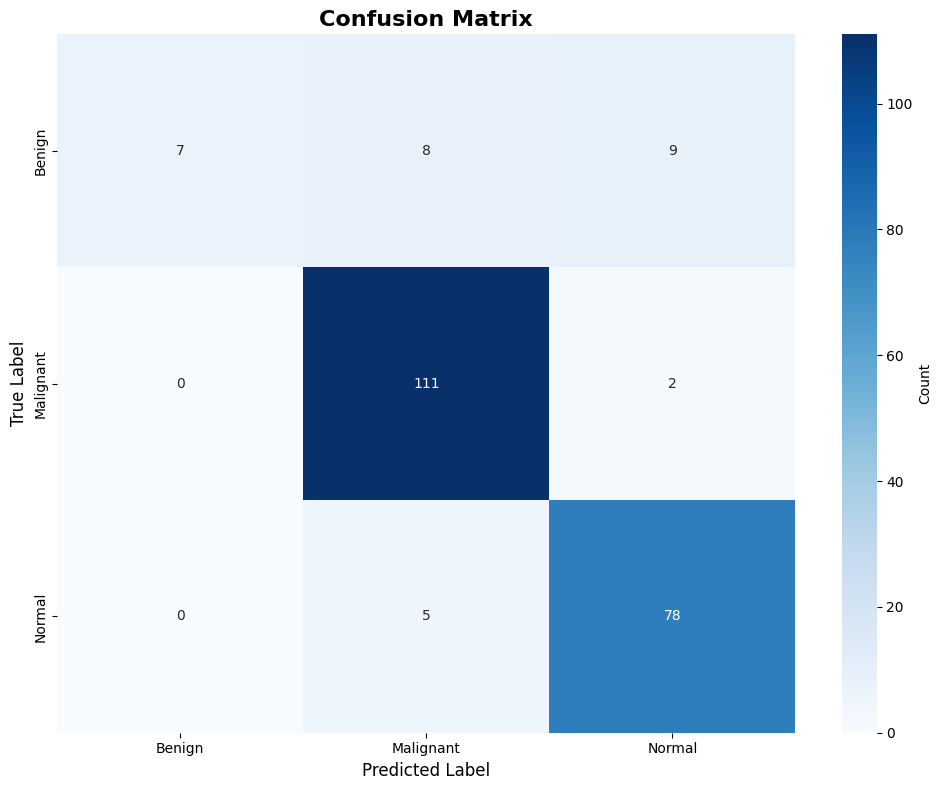

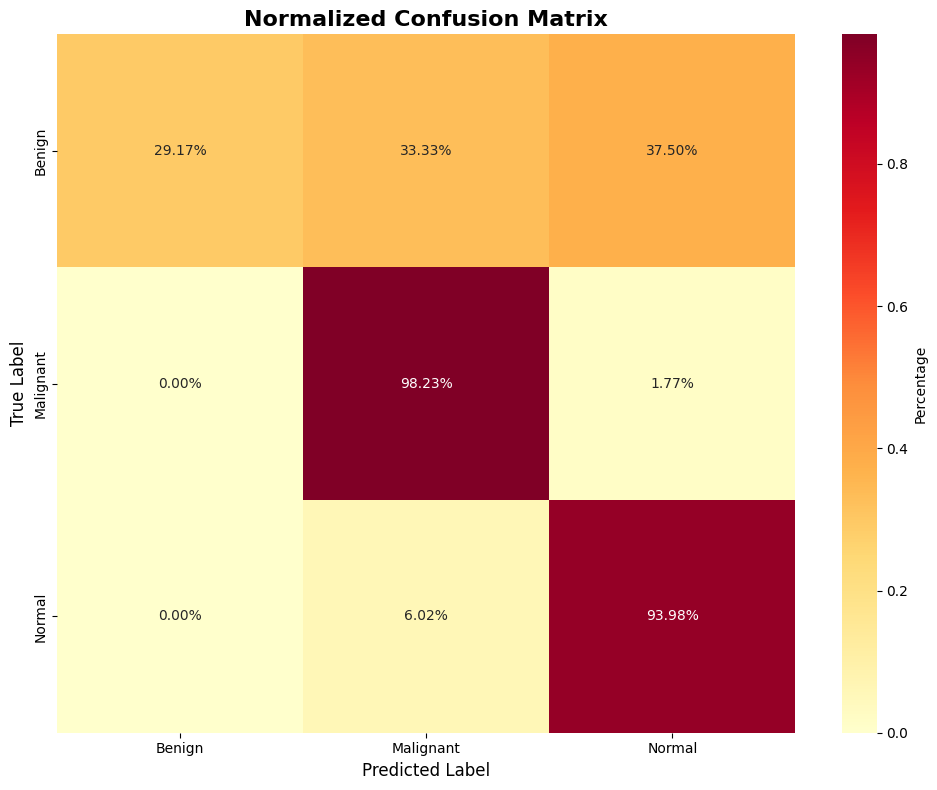

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('/content/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('/content/confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

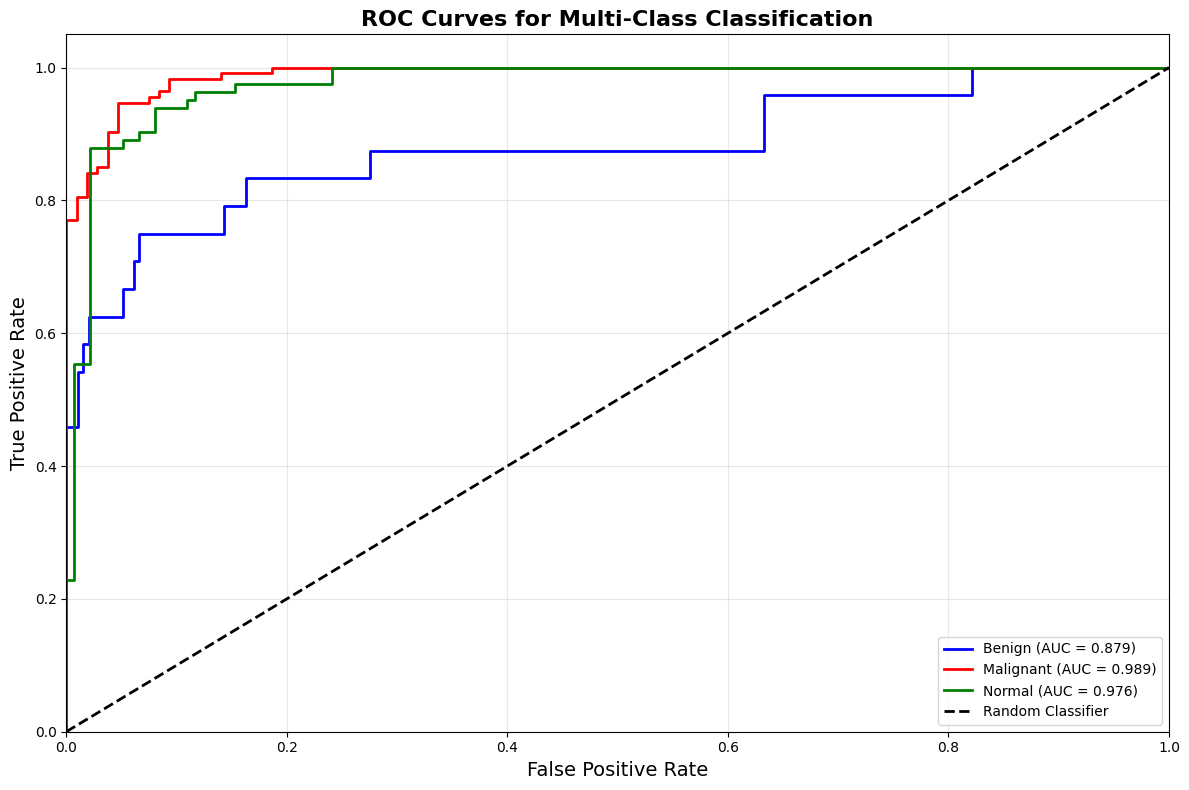

In [ ]:
# Plot ROC Curves
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize labels for ROC curve
y_test_bin = label_binarize(y_true, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Multi-Class Classification', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

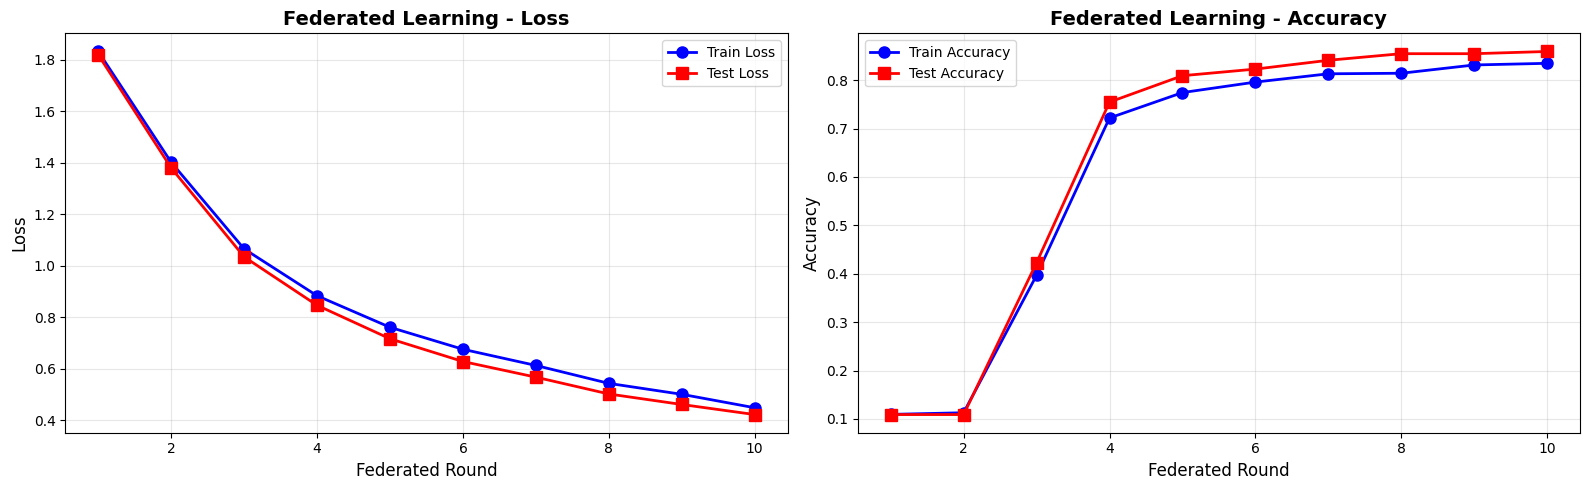

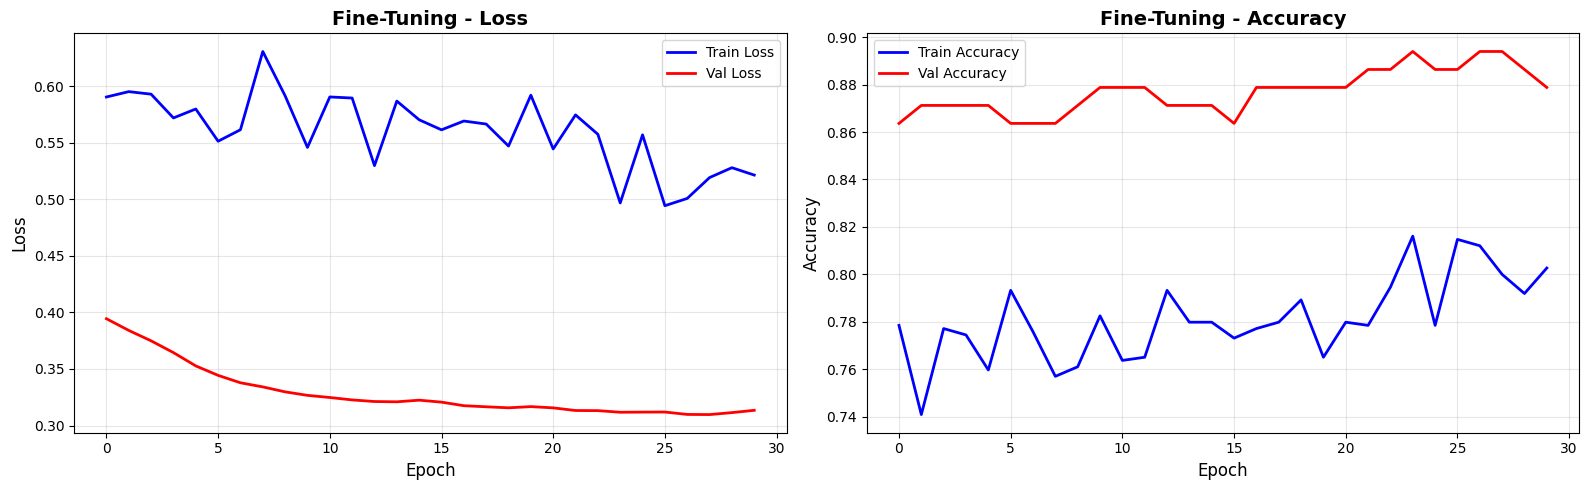

In [ ]:
# Plot Federated Learning Training History
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss plot
axes[0].plot(fl_history['round'], fl_history['train_loss'],
             'b-o', label='Train Loss', linewidth=2, markersize=8)
axes[0].plot(fl_history['round'], fl_history['test_loss'],
             'r-s', label='Test Loss', linewidth=2, markersize=8)
axes[0].set_xlabel('Federated Round', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Federated Learning - Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(fl_history['round'], fl_history['train_accuracy'],
             'b-o', label='Train Accuracy', linewidth=2, markersize=8)
axes[1].plot(fl_history['round'], fl_history['test_accuracy'],
             'r-s', label='Test Accuracy', linewidth=2, markersize=8)
axes[1].set_xlabel('Federated Round', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Federated Learning - Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/fl_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot fine-tuning history if available
if 'history_finetune' in locals():
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Loss
    axes[0].plot(history_finetune.history['loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(history_finetune.history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Fine-Tuning - Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history_finetune.history['accuracy'], 'b-', label='Train Accuracy', linewidth=2)
    axes[1].plot(history_finetune.history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Fine-Tuning - Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/finetuning_history.png', dpi=300, bbox_inches='tight')
    plt.show()


Per-Class Performance:
    Class  Precision   Recall  F1-Score  Support
   Benign   1.000000 0.291667  0.451613       24
Malignant   0.895161 0.982301  0.936709      113
   Normal   0.876404 0.939759  0.906977       83


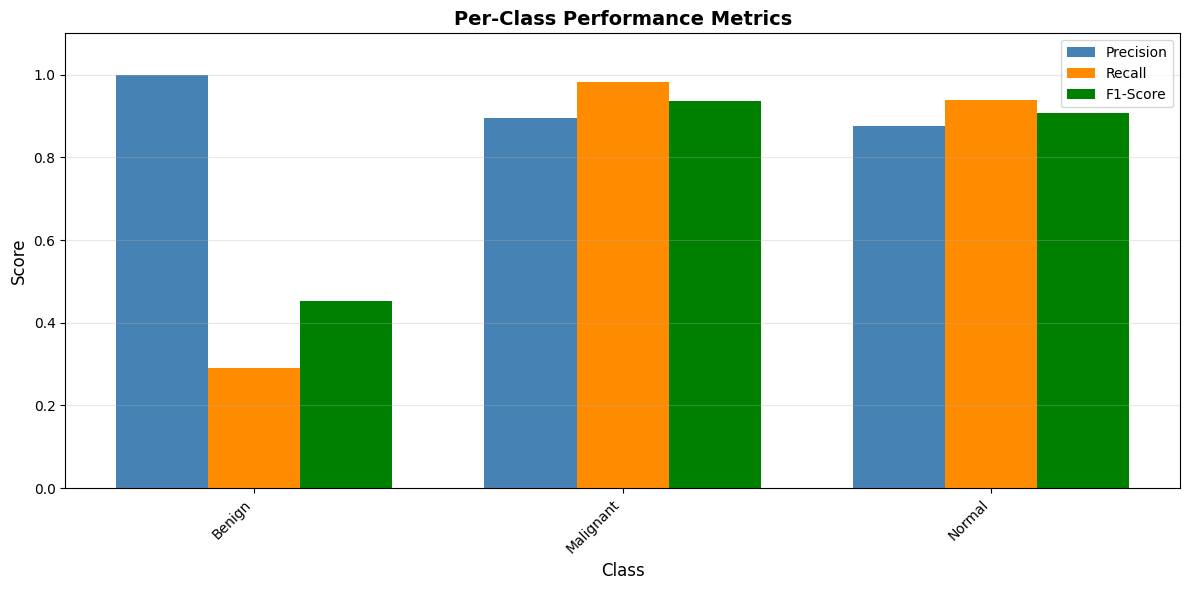

In [ ]:
# Per-class metrics visualization
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
    y_true, y_pred, average=None
)

# Create DataFrame for better visualization
metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support
})

print("\nPer-Class Performance:")
print(metrics_df.to_string(index=False))

# Plot per-class metrics
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

ax.bar(x - width, precision_per_class, width, label='Precision', color='steelblue')
ax.bar(x, recall_per_class, width, label='Recall', color='darkorange')
ax.bar(x + width, f1_per_class, width, label='F1-Score', color='green')

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig('/content/per_class_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Save all results to CSV
results_summary = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score',
               'Cohen Kappa', 'Matthews Correlation', 'AUC'],
    'Score': [accuracy, precision, recall, f1, cohen_kappa, mcc, auc_score]
}

results_df = pd.DataFrame(results_summary)
results_df.to_csv('/content/model_performance.csv', index=False)

metrics_df.to_csv('/content/per_class_metrics.csv', index=False)

# Save FL history
fl_history_df = pd.DataFrame(fl_history)
fl_history_df.to_csv('/content/fl_training_history.csv', index=False)

print("\n✓ All results saved successfully!")
print("Files saved:")
print("  - model_performance.csv")
print("  - per_class_metrics.csv")
print("  - fl_training_history.csv")
print("  - best_fl_model.h5")
print("  - best_finetuned_model.h5")
print("  - All visualization plots")


✓ All results saved successfully!
Files saved:
  - model_performance.csv
  - per_class_metrics.csv
  - fl_training_history.csv
  - best_fl_model.h5
  - best_finetuned_model.h5
  - All visualization plots


Sample Predictions:


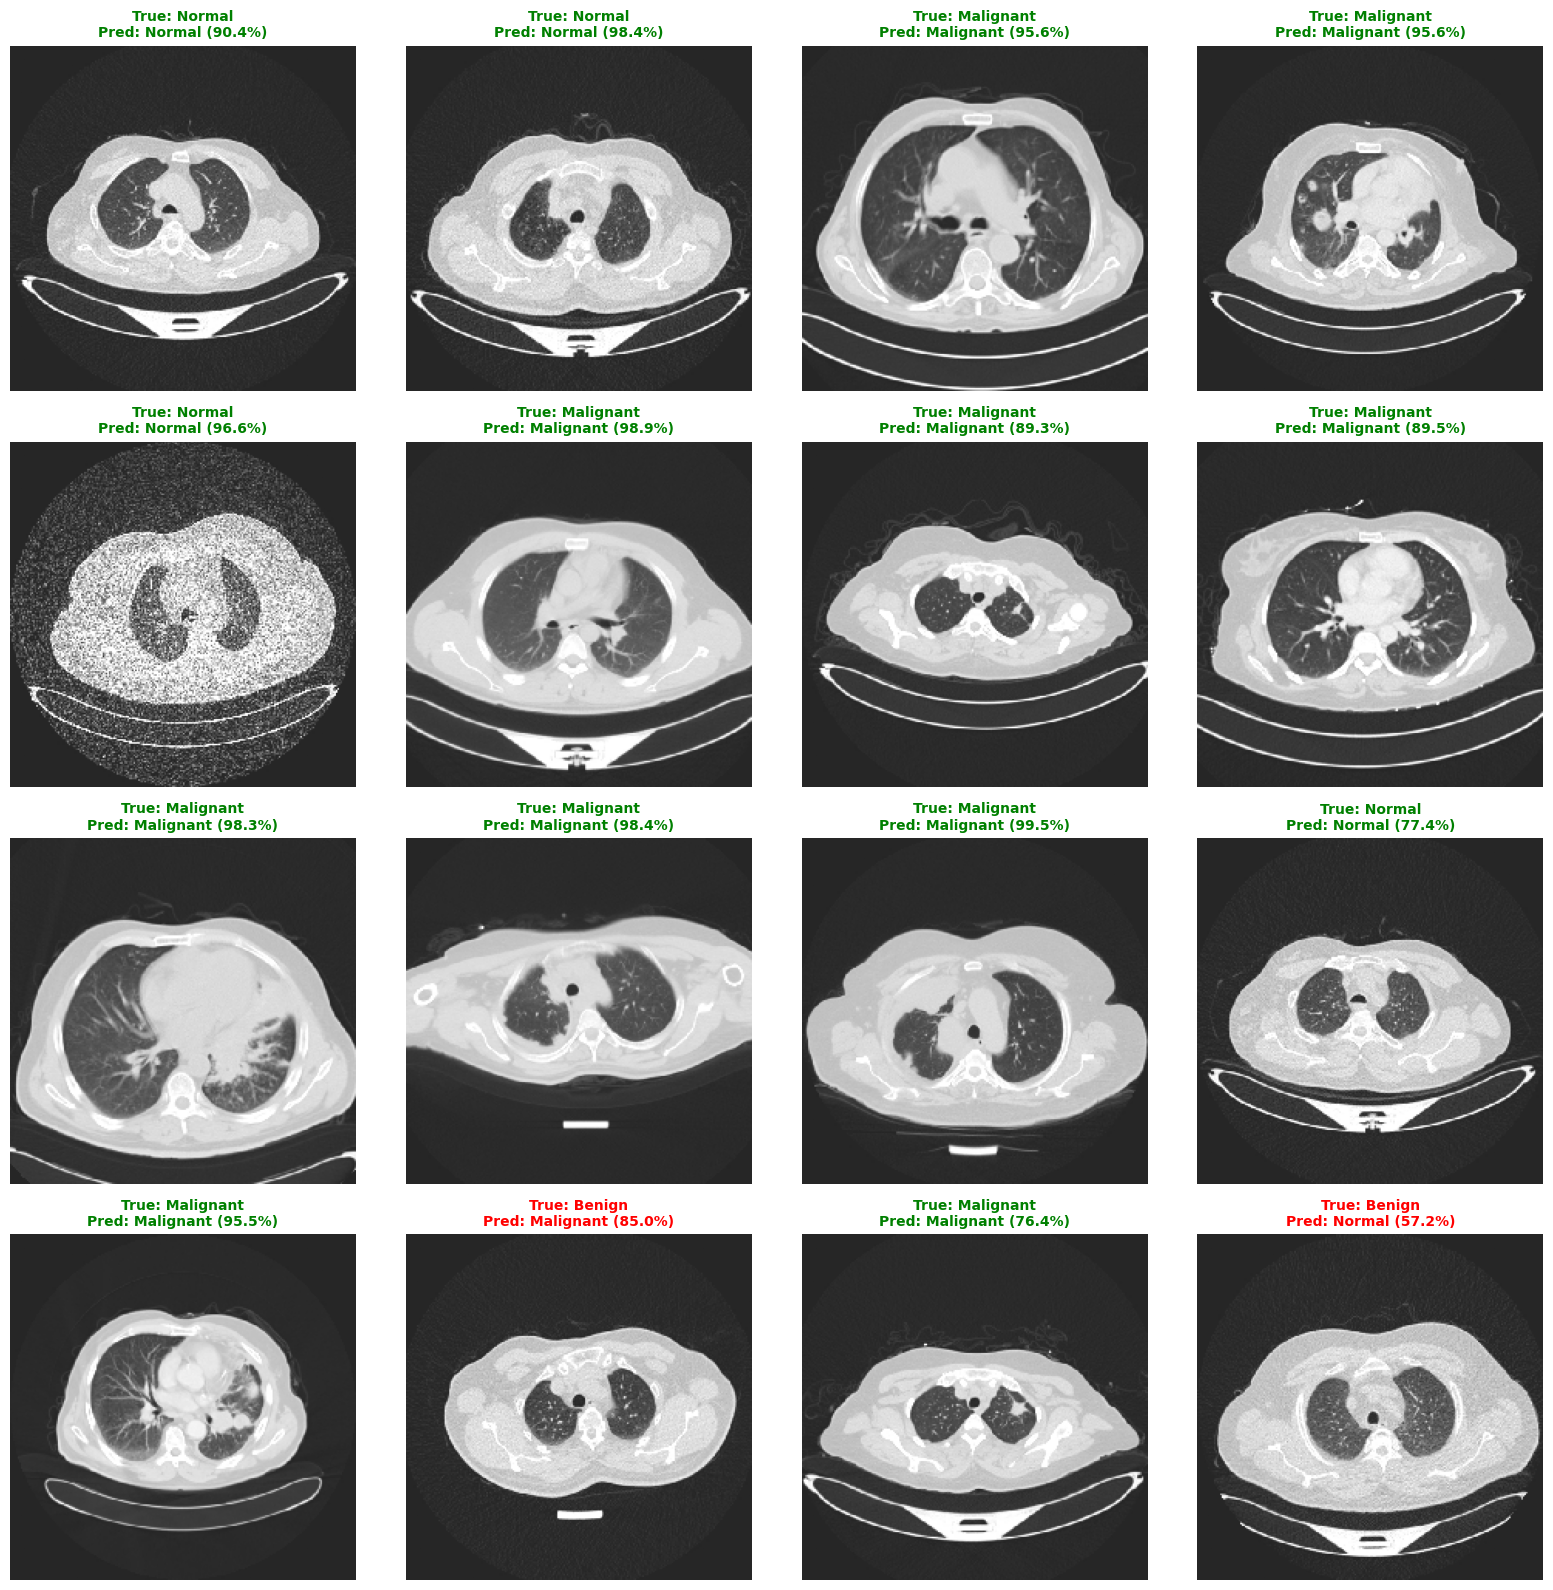

In [ ]:
# Visualize sample predictions
def plot_predictions(model, X, y_true, class_names, n_samples=16):
    """
    Plot sample predictions
    """
    # Get random samples
    indices = random.sample(range(len(X)), min(n_samples, len(X)))

    # Predict
    predictions = model.predict(X[indices], verbose=0)
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_true[indices], axis=1)

    # Plot
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        axes[i].imshow(X[idx])

        true_label = class_names[true_classes[i]]
        pred_label = class_names[pred_classes[i]]
        confidence = predictions[i][pred_classes[i]] * 100

        color = 'green' if true_classes[i] == pred_classes[i] else 'red'

        title = f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)"
        axes[i].set_title(title, color=color, fontsize=10, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('/content/sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Sample Predictions:")
plot_predictions(best_model, X_test, y_test, class_names)